In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import xgboost as xgb
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if str(filename) == 'sample_submission.csv' or str(filename) == 'store.csv':
            if str(filename) == 'store.csv':
                store_data_path = Path(os.path.join(dirname, filename))
            continue
        print(os.path.join(dirname, filename))
        paths.append(Path(os.path.join(dirname, filename)))

/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [3]:
dat = {}
for i in paths:
    with open(i,'r') as f:
        dat[i.stem] = pd.read_csv(f)
dat_org = dat['train']
for i in dat:
    dat[i]['Sex'], _ = pd.factorize(dat[i]['Sex'])
    dat[i]['Belastung'] = dat[i]['Heart_Rate'] * dat[i]['Duration']
    dat[i]['Belastung_2'] = dat[i]['Body_Temp'] * dat[i]['Duration']
    dat[i]['Body_type'] = dat[i]['Height'] * dat[i]['Age'] *  dat[i]['Weight']



In [4]:
dat['test'].head(5)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Belastung,Belastung_2,Body_type
0,750000,0,45,177.0,81.0,7.0,87.0,39.8,609.0,278.6,645165.0
1,750001,0,26,200.0,97.0,20.0,101.0,40.5,2020.0,810.0,504400.0
2,750002,1,29,188.0,85.0,16.0,102.0,40.4,1632.0,646.4,463420.0
3,750003,1,39,172.0,73.0,20.0,107.0,40.6,2140.0,812.0,489684.0
4,750004,1,30,173.0,67.0,16.0,94.0,40.5,1504.0,648.0,347730.0


In [5]:
dat['train'].head(5)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Belastung,Belastung_2,Body_type
0,0,0,36,189.0,82.0,26.0,101.0,41.0,150.0,2626.0,1066.0,557928.0
1,1,1,64,163.0,60.0,8.0,85.0,39.7,34.0,680.0,317.6,625920.0
2,2,1,51,161.0,64.0,7.0,84.0,39.8,29.0,588.0,278.6,525504.0
3,3,0,20,192.0,90.0,25.0,105.0,40.7,140.0,2625.0,1017.5,345600.0
4,4,1,38,166.0,61.0,25.0,102.0,40.6,146.0,2550.0,1015.0,384788.0


In [6]:
heatmap = dat['train'].corr(method='pearson', min_periods=1, numeric_only=True)['Calories']

heatmap = heatmap.to_frame()

heatmap.style.background_gradient(cmap='coolwarm').format(precision=2)

,Calories
id,0.00
Sex,-0.01
Age,0.15
Height,-0.00
Weight,0.02
Duration,0.96
Heart_Rate,0.91
Body_Temp,0.83
Calories,1.00
Belastung,0.98


In [7]:
heatmap = dat['train'].corr(method='pearson', min_periods=1, numeric_only=False)
heatmap.style.background_gradient(cmap='coolwarm').format(precision=2)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Belastung,Belastung_2,Body_type
id,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Sex,0.00,1.00,-0.01,-0.76,-0.82,0.01,-0.01,0.02,-0.01,0.01,0.01,-0.45
Age,0.00,-0.01,1.00,0.01,0.07,0.02,0.02,0.03,0.15,0.02,0.02,0.81
Height,0.00,-0.76,0.01,1.00,0.96,-0.03,-0.01,-0.03,-0.00,-0.03,-0.03,0.55
Weight,0.00,-0.82,0.07,0.96,1.00,-0.02,-0.00,-0.02,0.02,-0.02,-0.02,0.61
Duration,0.00,0.01,0.02,-0.03,-0.02,1.00,0.88,0.90,0.96,0.99,1.00,-0.00
Heart_Rate,0.00,-0.01,0.02,-0.01,-0.00,0.88,1.00,0.80,0.91,0.91,0.88,0.01
Body_Temp,0.00,0.02,0.03,-0.03,-0.02,0.90,0.80,1.00,0.83,0.88,0.90,0.01
Calories,0.00,-0.01,0.15,-0.00,0.02,0.96,0.91,0.83,1.00,0.98,0.96,0.13
Belastung,0.00,0.01,0.02,-0.03,-0.02,0.99,0.91,0.88,0.98,1.00,0.99,0.00


In [8]:
X = dat['train'].drop(["Calories"], axis=1)
y = dat['train']['Calories']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

rf = RandomForestRegressor(random_state=42)


In [10]:
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 15, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'max_features': ['auto', 'sqrt'],
#     'bootstrap': [True],
# }

# param_grid = {'bootstrap': [True], 'max_depth': [20], 'max_features': ['sqrt'], 'min_samples_leaf': [1], 'min_samples_split': [5], 'n_estimators': [200]}

# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=3,
#     n_jobs=-1,
#     verbose=2,
#     scoring='neg_mean_squared_error'
# )

best_rf = RandomForestRegressor(
    bootstrap=True,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

In [11]:
best_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.1min finished


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=5,
                      n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

In [12]:
y_pred = best_rf.predict(X_val)

y_pred = np.maximum(0, y_pred)
y_test = np.maximum(0, y_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.1s finished


RMSLE: 0.06048352462256901


<function matplotlib.pyplot.show(close=None, block=None)>

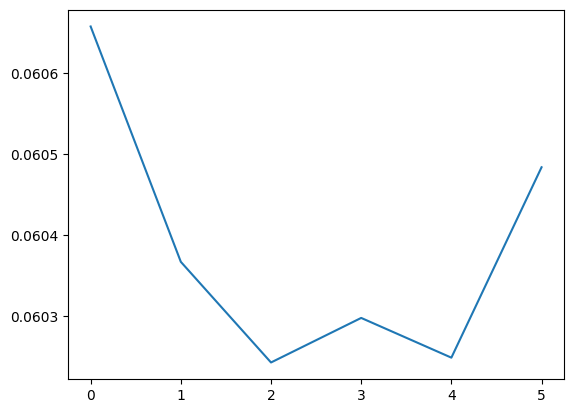

In [13]:
rmsle_value = np.sqrt(mean_squared_log_error(y_test, y_pred))

print("RMSLE:", rmsle_value)

res = [0.06065696859686999,0.060367018170745426,0.06024301895486139,0.06029790983393293,0.060248955909644755, 0.06048352462256901]
plt.plot(res)
plt.show

In [14]:
X_test = dat['test']

submission = pd.DataFrame()

submission['id'] = X_test['id']

submission['Calories'] = best_rf.predict(X_test)

submission.to_csv("submission.csv", index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    9.2s finished
